In [1]:
from quantum_electron import FullModel, QuantumAnalysis, PotentialVisualization
from quantum_electron.utils import r2xy, select_outer_electrons, density_from_positions
from scipy.constants import electron_mass as me, elementary_charge as qe
from matplotlib import pyplot as plt
import numpy as np

In this notebook we'll study a potential well with a flat bottom. The eigenmodes in such a potential are often studied in the Corbino disk geometry, so it is of interest to the electron on helium community. 

# Create the potential

We have to be careful with defining the potential, because sharp boundaries cause issues with the solution. This is because there is some smoothing in the interpolation, which can cause artefacts and intended potential minima. Therefore, we create a hyperbolic tangent potential with a transition that can be tuned.

In [2]:
# Note that the units of x and y are implicitly assumed as microns
x = np.linspace(-2, 2, 201)
y = np.linspace(-2, 2, 201)

micron = 1e-6

X, Y = np.meshgrid(x, y)
X *= micron
Y *= micron

R = np.sqrt(X ** 2 + Y ** 2)
R0 = 1.5e-6

# The parameter in front of R - R0, tunes how sharp the boundary is.
hard_confinement = -0.5 * np.tanh(5 * (R - R0) / micron)

# outside the circle there is a guard ring
hard_confinement -= .5

# also add the guard ring
guard_ring = np.ones(X.shape)
guard_ring[R < R0] = 0 

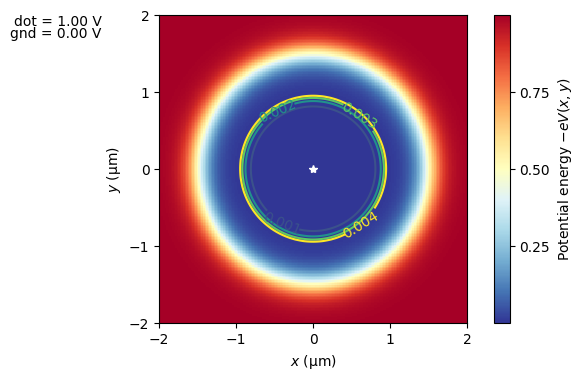

In [3]:
potential_dict = {"dot" : hard_confinement, 
                  "gnd" : guard_ring, 
                  "xlist" : x, 
                  "ylist" : y}

# Let's apply these voltages to the corresponding electrodes in potential_dict
voltages = {"dot" : 1.0, 
            "gnd" : 0}

p = PotentialVisualization(potential_dict, voltages)
p.plot_potential_energy(dxdy=(4, 4))

# Adding electrons

In this case we are interested in the many electron limit, since the Corbino geometry is often used to study many-body physics for electrons on helium. Let's add a few hundred electrons to this geometry. This is typically much more challenging for the optimization code, since the size of matrices increases as $(2n)^2$. 

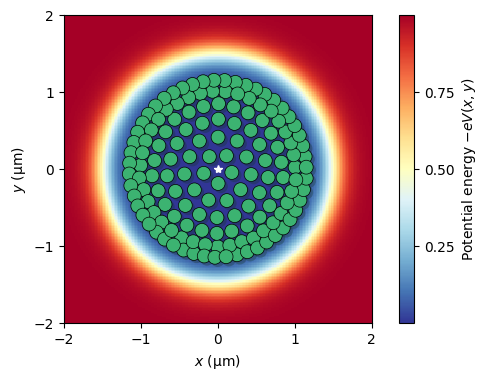

In [4]:
n_electrons = 150

fm = FullModel(potential_dict=potential_dict, voltage_dict=voltages, trap_annealing_steps=[4.0]*5)

res = fm.get_electron_positions(n_electrons=n_electrons, electron_initial_positions=None, verbose=False)

fm.plot_potential_energy(ax=None, dxdy=(4, 4), print_voltages=False, plot_contours=False)
fm.plot_electron_positions(res, ax=None)

To check the convergence we can monitor it directly during the convergence by setting `verbose=True` in `get_electron_positions`, or we can call `plot_convergence()` after the optimization has completed.

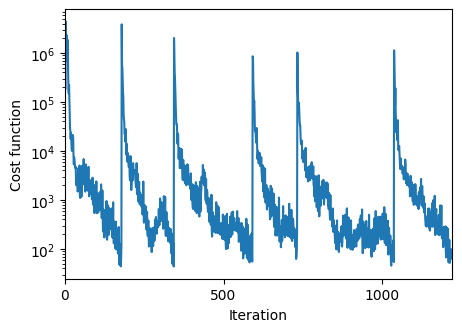

In [5]:
fm.plot_convergence()

# Density vs. radial position

Since the eigenmodes of this system are expected to depend on the electron density and _not_ on the applied voltage, we need a way to study electron density. Let's do that here:

Density = 3.84e+13 m^-2


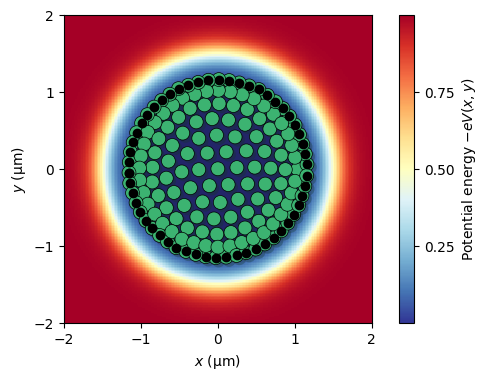

In [6]:
n_electrons = 160

fm = FullModel(potential_dict=potential_dict, voltage_dict=voltages, trap_annealing_steps=[4.0]*5)

res = fm.get_electron_positions(n_electrons=n_electrons, electron_initial_positions=None, verbose=False)

final_x, final_y = r2xy(res['x'])

fm.plot_potential_energy(ax=None, dxdy=(4, 4), print_voltages=False, plot_contours=False)
fm.plot_electron_positions(res, ax=None)
poly_pts, area = select_outer_electrons(final_x, final_y, color='k', lw=3, plot=True)

n = fm.count_electrons_in_dot(res['x'], trap_bounds_x=(-2, 2), trap_bounds_y=(-2, 2))
# area = fm.get_dot_area(barrier_location=(-2, 0), barrier_offset=-0.3, plot=True)

n_s = n / area / micron ** 2
print(f"Density = {n_s:.2e} m^-2")

We can get an easy estimate of the average density in units of $m^{-2}$

In [7]:
density_from_positions(final_x, final_y)/1e13

1.2297033715009993

In [8]:
Xi, Yi = np.meshgrid(final_x, final_y)
Xj, Yj = Xi.T, Yi.T

XiXj = Xi - Xj
YiYj = Yi - Yj

Rij_standard = np.sqrt((XiXj) ** 2 + (YiYj) ** 2)
np.fill_diagonal(Rij_standard, 5e-6)

nearest_neighbor_distance = np.min(Rij_standard, axis=1)

Text(0, 0.5, 'Local density (cm$^{-2}$)')

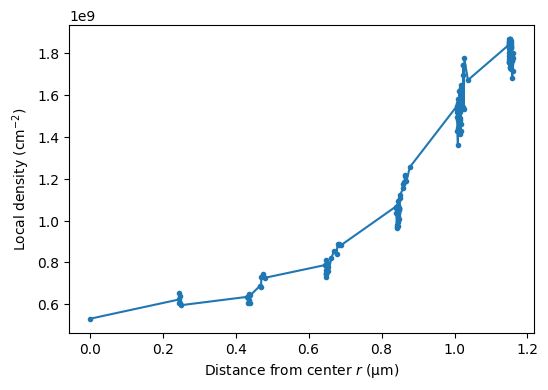

In [9]:
ri = np.sqrt(final_x **2  + final_y ** 2)

order = np.argsort(ri)

fig = plt.figure(figsize=(6.,4.))
plt.plot(ri[order] / micron, 1e-4 / (np.pi * nearest_neighbor_distance[order] ** 2 ), '.-')
plt.xlabel(f"Distance from center $r$ ({chr(956)}m)")
plt.ylabel(r"Local density (cm$^{-2}$)")

# Study eigenmodes

The eigenmodes of the system are given by $\omega_p^2 = 2\pi N e^2 k / m_e$, where $N$ is the electron density per unit area, and $k \approx \pi / L$ is the wave vector. More can be found in this paper:  https://www.sciencedirect.com/science/article/abs/pii/0039602876901539 

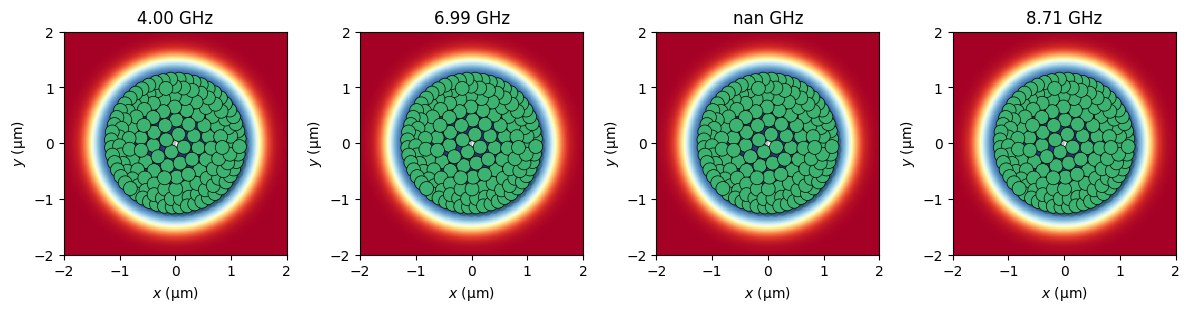

In [11]:
mode_idcs = range(0, 4)
n_electrons = 150

fig, ax = plt.subplots(1, len(mode_idcs), figsize=(len(mode_idcs) * 3, 6))
fm = FullModel(potential_dict=potential_dict, voltage_dict=voltages, trap_annealing_steps=[1.0]*10)
res = fm.get_electron_positions(n_electrons=n_electrons, electron_initial_positions=None)
fm.set_rf_interpolator(rf_electrode_labels=['dot', 'gnd'])

for k, m in enumerate(mode_idcs):
    fm.plot_potential_energy(ax=ax[k], dxdy=(4, 4), print_voltages=False, plot_contours=False)

    K, M = fm.setup_eom(res['x'])
    efreqs, evecs = fm.solve_eom(K, M, sort_by_cavity_participation=True)

    ax[k].set_title(f"{efreqs[m]/1e9:.2f} GHz")

fig.tight_layout()
anim = fm.animate_eigenvectors(fig, ax, evecs.T, res['x'], amplitude=0.5e-7)

In [12]:
fm.show_animation(anim)

There are now hundreds of eigenmodes, at very high frequencies.

Text(0, 0.5, '$\\sqrt{2}\\omega / \\omega_0$')

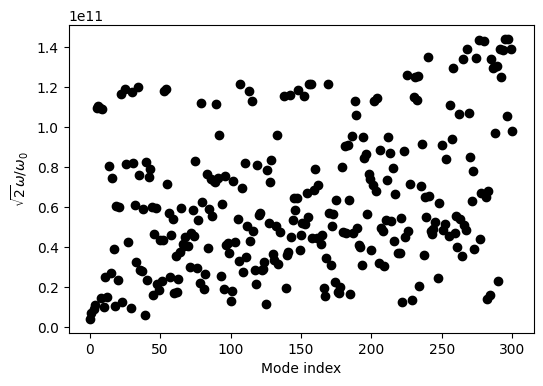

In [13]:
plt.figure(figsize=(6., 4.))
plt.plot(efreqs, 'ok')
plt.xlabel("Mode index")
plt.ylabel(r"$\sqrt{2}\omega / \omega_0$")

In [14]:
k = np.pi / R0

f_theory = np.sqrt(2 * np.pi * n_s * qe ** 2 * k / me) / (2 * np.pi)
print(f_theory)

600678.3706880936
